In [1]:
import pandas as pd
import missingno
import re
from konlpy.tag import Okt
import tqdm
import numpy as np
from collections import Counter
# 레티나 디스플레이로 폰트가 선명하게 표시되도록 합니다.
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# 라이브러리를 로드합니다.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 한글폰트를 설정합니다.
plt.rc('font',family='AppleGothic')
plt.rc('axes',unicode_minus=False)

import torch
import torch.utils
import torch.utils.data

In [2]:
df_train = pd.read_csv('ratings_train.txt',sep='\t')
df_test = pd.read_csv('ratings_test.txt',sep='\t')

for enumerate

In [3]:
for table in (df_train,df_test):
    print(f"데이터 개수",table.shape)
    print("nan 여부",table['label'].isnull().unique())
    print("중복 데이터 개수",table.shape[0]-table['document'].nunique())
    print("클래스별 개수",table.groupby('label').size())
    print()

데이터 개수 (150000, 3)
nan 여부 [False]
중복 데이터 개수 3818
클래스별 개수 label
0    75173
1    74827
dtype: int64

데이터 개수 (50000, 3)
nan 여부 [False]
중복 데이터 개수 843
클래스별 개수 label
0    24827
1    25173
dtype: int64



## 실습
- document 컬럼에서 중복 값을 제거
- document 컬럼에서 NaN 값을 제거
- document 컬럼에서 한글, 공백을 제외한 모든 텍스트를 제거
- 1~3번 전처리를 한 뒤, 비어있는 데이터 제거
- 전처리가 끝난 뒤, 데이터 개수 변화 확인

In [4]:
regex = (r"[^가-힣ㄱ-ㅎ-ㅏ-ㅣ\s]")
for table in (df_train,df_test):
    table.drop_duplicates(inplace=True,subset=['document'])
    table['document'] = table['document'].str.replace(pat=regex,repl="",regex=True)
    table['document'] = table['document'].str.replace(pat=(r"[ +]"),repl="",regex=True)
    table['document'] = table['document'].replace('',float('nan'))
    table.dropna(how='any',inplace=True)
    
    print('전처리 후 데이터 개수 : ',table.shape)


전처리 후 데이터 개수 :  (145420, 3)
전처리 후 데이터 개수 :  (48855, 3)


형태소 분석
- 불용어 처리
- 한글자 단어는 제외
- train/test/valid = 4000:2000:1000
- train/test/valid 데이터 각 클래스별 비율 확인하기
- train set에서 등장하는 모든 단어 모든 목록 확인

불용어 처리


In [5]:
okt = Okt()

In [6]:
f = open('./stopwords-ko.txt',encoding='utf8')
stopwords = f.readlines()
stopwords = [s[:-1] for s in stopwords]

In [7]:
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [8]:
X_train = []
y_train = []
for i in tqdm.tqdm(range(0,4000)):
    sentence = df_train['document'][i]
    y_train.append(df_train['label'][i])
    tokenized = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized if not word in stopwords and len(word) >= 2]
    if stopwords_removed_sentence == []: continue
    X_train.append(stopwords_removed_sentence)
    
X_test = []
y_test = []
for i in tqdm.tqdm(range(0,2000)):
    sentence = df_test['document'][i]
    y_test.append(df_test['label'][i])
    tokenized = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized if not word in stopwords and len(word) >= 2]
    if stopwords_removed_sentence == []: continue
    X_test.append(stopwords_removed_sentence)
    
X_valid = []
y_valid = []
for i in tqdm.tqdm(range(10000,11000)):
    sentence = df_test['document'][i]
    y_valid.append(df_test['label'][i])
    tokenized = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized if not word in stopwords and len(word) >= 2]
    if stopwords_removed_sentence == []: continue
    X_valid.append(stopwords_removed_sentence)

100%|██████████| 1000/1000 [00:09<00:00, 101.56it/s]


In [9]:
for n in ('train','test','valid'):
    t = globals()['y_'+n]
    print(f"{n}긍정 데이터 비율 : ",sum(t) / len(t))
    print(f"{n}부정 데이터 비율 : ",sum(np.array(t) == 0 ) / len(t))
    print()

train긍정 데이터 비율 :  0.49925
train부정 데이터 비율 :  0.50075

test긍정 데이터 비율 :  0.512
test부정 데이터 비율 :  0.488

valid긍정 데이터 비율 :  0.495
valid부정 데이터 비율 :  0.505



In [10]:
word_list =[]
for sent in X_train:
    for word in sent:
        word_list.append(word)

In [11]:
word_counts = Counter(word_list)

In [12]:
len(word_counts) # 고유한 단어 개수

7356

In [13]:
word_counts_dict = dict(word_counts.most_common())

In [14]:
new_word_count_dict = {}
for k,v in word_counts_dict.items():
    if v >= 3:
        new_word_count_dict[k] = v

In [15]:
len(new_word_count_dict)

1902

In [16]:
# vocab = sorted(word_counts, key=word_counts.get,reverse=True)

In [17]:
# vocab[:10] # 상위 10개

실습
1. 빈출 단어 시각화
2. 빈도가 3번 초과하지 않은 데이터는 제거

---

In [18]:
word_df = pd.DataFrame.from_dict(word_counts,orient='index')

In [19]:
pd.DataFrame(word_counts.most_common(),columns=["영화",'카운트'])

,영화,카운트
0,영화,1179
1,보다,1001
2,하다,676
3,없다,433
4,이다,354
...,...,...
7351,김민정,1
7352,스탠리,1
7353,깃털,1
7354,흑백영화,1


In [20]:
word_df.sort_values(0,ascending=False,inplace=True)

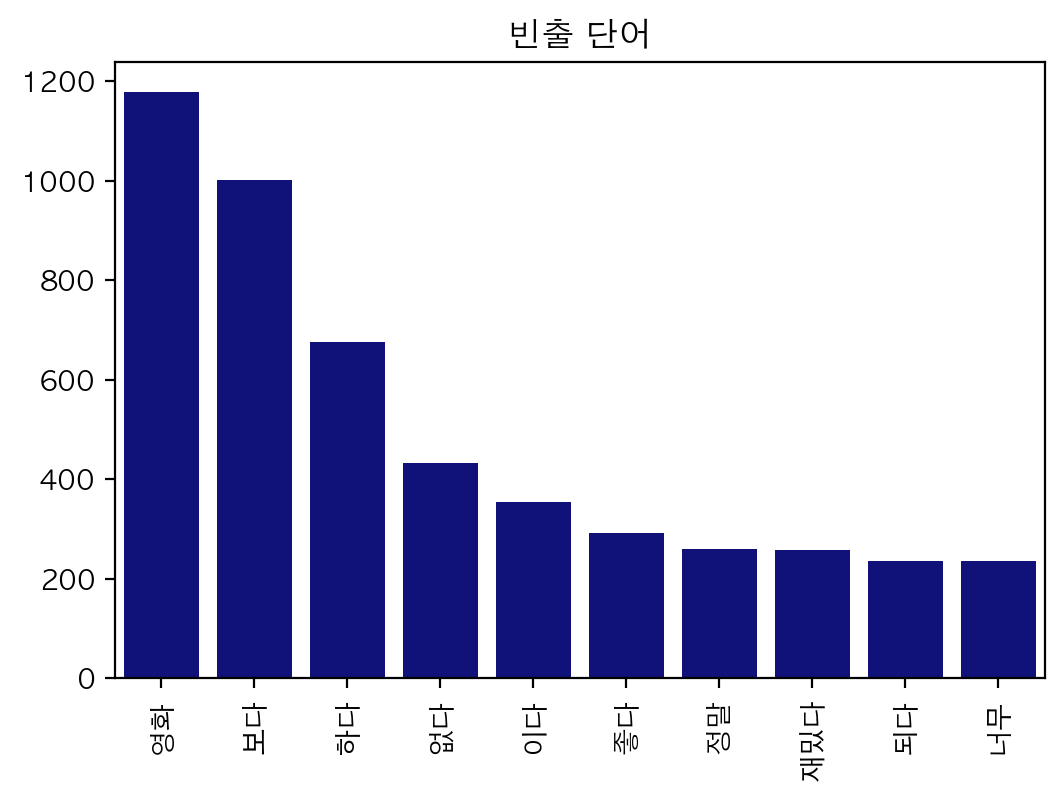

In [21]:
plt.subplots(figsize=(6,4))
sns.barplot(word_df.iloc[0:10].T,color='darkblue')
plt.xticks(rotation=90)
plt.title('빈출 단어')
plt.show()

In [22]:
rm_list = []
for k,v in word_counts.items():
    if v <= 3:
        rm_list.append(k)

In [23]:
for X in ('X_train', 'X_test','X_valid'):
    globals()[X] = [[x2 for x2 in x if x2 not in rm_list] for x in globals()[X]]

In [24]:
for t in ('train', 'test','valid'):
    rng = len(globals()['X_'+t])
    
    globals()['X2_'+t] = []
    globals()['y2_'+t] = []
    for i in range(rng):
        if globals()['X_'+t][i] == []:
            continue
        else:
             globals()['X2_'+t].append(globals()['X_'+t][i])
             globals()['y2_'+t].append(globals()['y_'+t][i])

In [25]:
word_list =[]
for sent in X2_train:
    for word in sent:
        word_list.append(word)
word_counts = Counter(word_list)        
vocab = sorted(word_counts, key=word_counts.get,reverse=True)

In [26]:
word_to_index = {}
word_to_index['<PAD>'] = 0 # 공백
word_to_index['<UNK>'] = 1 # 

In [27]:
word_to_index

{'<PAD>': 0, '<UNK>': 1}

In [28]:
for ind, word in enumerate(vocab):
    word_to_index[word] = ind+2

In [29]:
def text_to_seq(X, word_to_index=word_to_index):
    X_enc = []
    
    for sent in X:
        ind_seq = []
        
        for word in sent:
            try:
                ind_seq.append(word_to_index[word])
            except KeyError:
                ind_seq.append(word_to_index['<UNK>'])
        X_enc.append(ind_seq)
    return X_enc

In [31]:
X2_train = text_to_seq(X2_train)
X2_test = text_to_seq(X2_test)
X2_valid = text_to_seq(X2_valid)

In [32]:
index_to_word = {}

for k,v in word_to_index.items():
    index_to_word[v] = k

In [33]:
def seq_to_text(X, word_to_index=word_to_index):
    X_dec = []
    
    for sent in X:
        ind_text = []
        
        for word in sent:
            ind_text.append(index_to_word[word])
                
        X_dec.append(ind_text)
    return X_dec

In [34]:
seq_to_text(X2_valid)

[['<UNK>', '크다', '<UNK>', '때문', '보다', '서다', '거지', '남다', '주다'],
 ['지루', '정도'],
 ['정도', '아니다', '<UNK>', '<UNK>', '너무', '허무하다', '죽다', '서점'],
 ['여자',
  '<UNK>',
  '<UNK>',
  '<UNK>',
  '<UNK>',
  '여자',
  '<UNK>',
  '이다',
  '나오다',
  '남자',
  '<UNK>',
  '<UNK>',
  '이다',
  '입다'],
 ['너무', '재미있다', '보다'],
 ['최근', '보다', '이영화', '가다', '좋다'],
 ['<UNK>',
  '<UNK>',
  '항상',
  '새롭다',
  '<UNK>',
  '하다',
  '위해',
  '항상',
  '새롭다',
  '많이',
  '느끼다'],
 ['<UNK>', '라는', '충격', '현실'],
 ['확실하다', '영화', '개봉', '만에', '평가', '되다', '아니다', '지금', '개봉', '보다', '깊이', '영화'],
 ['이영화', '긴장감', '존재', '않다'],
 ['정도', '되다', '되다', '평점', '낮다', '서점', '<UNK>', '여자', '그런', '긴장감', '보다', 'ㅠㅠ'],
 ['지루하다', '미치다', '<UNK>', '영화'],
 ['지루하다', '너무', '이라', '그렇다'],
 ['<UNK>', '한테', '어울리다'],
 ['최고', '매우', '사실', '드라마'],
 ['<UNK>', '영화', '마지막', '작품', '작품', '이후', '<UNK>'],
 ['<UNK>',
  '노래',
  '찾아보다',
  '더빙',
  'ㅋㅋㅋ',
  '떨다',
  '아직도',
  '쓰다',
  'ㅋㅋ',
  '성우',
  '죽음',
  '없다',
  'ㅋㅋ'],
 ['걸작', '이다'],
 ['되다', '코미디', '암튼', '뭔가', '<UNK>', '약하다', '추천'],
 ['겠다',

In [35]:
def pad_seq(sentences, max_len=30):
    features = np.zeros((len(sentences),max_len),dtype=int)
    
    for ind, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[ind, :len(sentence)] = np.array(sentence)[:max_len]
            
    return features

In [36]:
X_train_pad = pad_seq(X2_train)
X_test_pad = pad_seq(X2_test)
X_valid_pad = pad_seq(X2_valid)

In [37]:
device = torch.device('cpu')

In [38]:
train_label_tensor = torch.tensor(np.array(y2_train))
test_label_tensor = torch.tensor(np.array(y2_test))
valid_label_tensor = torch.tensor(np.array(y2_valid))

In [39]:
class TextClassifier(torch.nn.Module):
    # vocab size : 단어 개수
    def __init__(self, vocab_size,embedding_dim,hidden_dim,output_dim):
        super(TextClassifier,self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size,embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim,hidden_dim,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
    def forward(self, x):
        # x : batch_size, seq_Length
        embedded = self.embedding(x)
        
        lstm_out,(hidden,cell) = self.lstm(embedded)
        
        last_hidden = hidden.squeeze(0)
        logits = self.fc(last_hidden)
        return logits
        

In [40]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2 # binary
learning_rate = 0.01
num_epochs =10
vocab_size = len(word_to_index)

model = TextClassifier(vocab_size,embedding_dim,hidden_dim,output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(1375, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [41]:
encoded_train = torch.tensor(X_train_pad).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train,train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=32)

encoded_test = torch.tensor(X_test_pad).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test,test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=32)

encoded_valid = torch.tensor(X_valid_pad).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid,valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,shuffle=True,batch_size=32)

In [42]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [43]:
def calculate_acc(logits, labels):
    predict = torch.argmax(logits,dim=1)
    correct = (predict == labels).sum().item()
    total =labels.size(0)
    acc = correct/total
    return acc

In [46]:
def evaluate(model, valid_dataloader, criterion=criterion, device=device):
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    model.eval()
    with torch.no_grad():
        # valid_dataloader에서 배치 가져오기
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            logits = model(batch_X)  # 모델로 예측
            loss = criterion(logits, batch_y)  # 손실 계산
            
            val_loss += loss.item()
            val_correct += calculate_acc(logits, batch_y) * batch_y.size(0)  # 정확도 계산
            val_total += batch_y.size(0)
    
    val_acc = val_correct / val_total  # 전체 정확도 계산
    val_loss /= len(valid_dataloader)  # 평균 손실 계산
    
    return val_loss, val_acc


In [54]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss, train_correct, train_total = 0,0,0
    model.train()
    
    for batch_X,batch_y in tqdm.tqdm(train_dataloader):
        batch_x, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)
        loss = criterion(logits,batch_y) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += calculate_acc(logits,batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)
        
    train_acc = train_correct / train_total
    train_loss /= len(train_dataloader)
    
    val_loss,val_acc = evaluate(model,valid_dataloader)
    
    print(f"epoch: {epoch+1} / {num_epochs}")
    print(f"train loss : {train_loss:.3f},train_acc : {train_acc:.3f}")
    print(f"valid loss : {val_loss:.3f},valid_acc : {val_acc:.3f}")
    
    if val_loss < best_val_loss:
        print(f"best val.loss saved; loss : {val_loss:.3f},valid_acc : {val_acc:.3f}")
        best_val_loss = val_loss
        torch.save(model.state_dict(),'./best_model.pth')

100%|██████████| 122/122 [00:02<00:00, 47.94it/s]


epoch: 1 / 10
train loss : 0.693,train_acc : 0.500
valid loss : 0.695,valid_acc : 0.496
best val.loss saved; loss : 0.695,valid_acc : 0.496


100%|██████████| 122/122 [00:02<00:00, 49.42it/s]


epoch: 2 / 10
train loss : 0.693,train_acc : 0.496
valid loss : 0.695,valid_acc : 0.493


100%|██████████| 122/122 [00:02<00:00, 45.46it/s]


epoch: 3 / 10
train loss : 0.693,train_acc : 0.506
valid loss : 0.696,valid_acc : 0.506


100%|██████████| 122/122 [00:02<00:00, 47.21it/s]


epoch: 4 / 10
train loss : 0.697,train_acc : 0.497
valid loss : 0.694,valid_acc : 0.492
best val.loss saved; loss : 0.694,valid_acc : 0.492


100%|██████████| 122/122 [00:02<00:00, 41.32it/s]


epoch: 5 / 10
train loss : 0.690,train_acc : 0.538
valid loss : 0.699,valid_acc : 0.486


100%|██████████| 122/122 [00:03<00:00, 39.29it/s]


epoch: 6 / 10
train loss : 0.672,train_acc : 0.589
valid loss : 0.715,valid_acc : 0.502


100%|██████████| 122/122 [00:03<00:00, 38.78it/s]


epoch: 7 / 10
train loss : 0.653,train_acc : 0.618
valid loss : 0.740,valid_acc : 0.505


100%|██████████| 122/122 [00:02<00:00, 42.35it/s]


epoch: 8 / 10
train loss : 0.633,train_acc : 0.646
valid loss : 0.758,valid_acc : 0.495


100%|██████████| 122/122 [00:02<00:00, 42.79it/s]


epoch: 9 / 10
train loss : 0.615,train_acc : 0.665
valid loss : 0.760,valid_acc : 0.492


100%|██████████| 122/122 [00:02<00:00, 43.32it/s]


epoch: 10 / 10
train loss : 0.590,train_acc : 0.686
valid loss : 0.789,valid_acc : 0.499


In [55]:
model.load_state_dict(torch.load('./best_model.pth'))

/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_83868/3794482924.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_mode

<All keys matched successfully>

In [56]:
model.to(device)

TextClassifier(
  (embedding): Embedding(1375, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [62]:
test_loss, test_acc = evaluate(model,test_dataloader)

In [63]:
print(test_loss,test_acc)

0.6987570841466227 0.5007602635580335


In [69]:
def predict(text,model,word_to_index=word_to_index):
    model.eval()
    
    tokens = okt.morphs(text,stem=True)
    tokens = [word for word in tokens if not word in stopwords]
    token_indices = [word_to_index.get(token,1) for token in tokens]
    
    input_tensor = torch.tensor([token_indices],dtype=torch.long).to(device)
    
    with torch.no_grad():
        logits = model(input_tensor)
        
    pred_ind = torch.argmax(logits, dim=1)
    
    return pred_ind

In [1539]:
if int(predict('디박!! 대박!!잼씀',model)) == 0:
    print('부정적 리뷰')
else:
    print('긍정적 리뷰')

부정적 리뷰


---

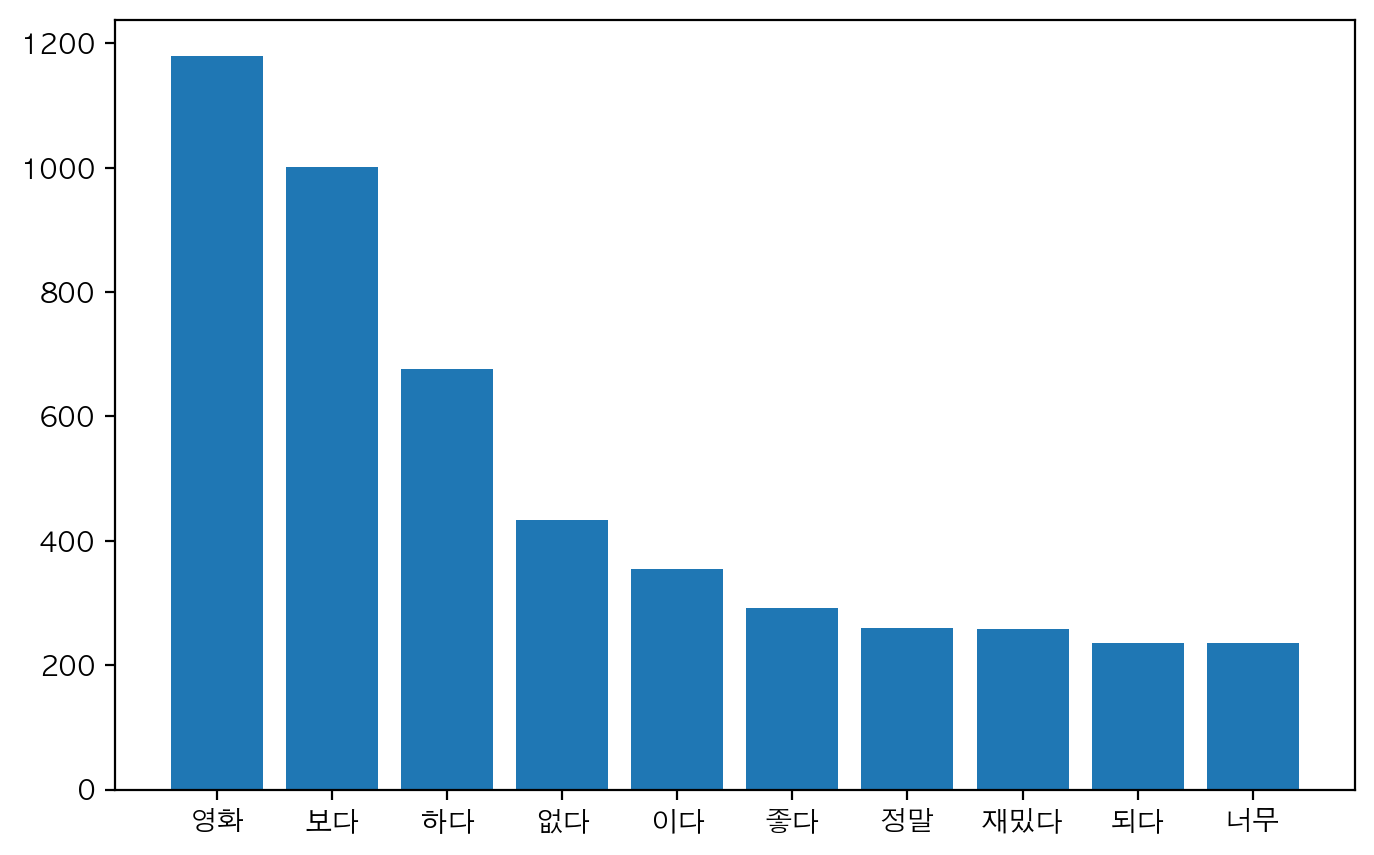

In [59]:
top10 = dict(Counter(new_word_count_dict).most_common(10))
plt.figure(figsize=(8,5))
plt.bar(top10.keys(), top10.values())
plt.show()